In [13]:
# Modeling
# import tensorflow as tf
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import StandardScaler

# import xgboost as xgb

# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Attention, Layer, GRU, Input, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from math import sqrt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import date, timedelta

# from cylib.apis.all_api import *

# Suppress the warning
# warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

# zscore = StandardScaler()

# Suppress the warning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
Main_bactest = True
path = 'D:\\AI_data_analysis\\CY\\'

In [14]:
MLP_factor_df = pd.read_csv(path + 'MLP_factor_df.csv',
                            parse_dates=['trade_date'],
                            index_col='trade_date')
GBDT_factor_df = pd.read_csv(path + 'GBDT_factor_df.csv',
                            parse_dates=['trade_date'],
                            index_col='trade_date')
GRU_factor_df = pd.read_csv(path + 'GRU_factor_df.csv',
                            parse_dates=['trade_date'],
                            index_col='trade_date')
AGRU_factor_df = pd.read_csv(path + 'AGRU_factor_df.csv',
                            parse_dates=['trade_date'],
                            index_col='trade_date')

price_return_test = pd.read_csv(path + 'price_return_test.csv',
                                parse_dates=['trade_date'],
                                index_col='trade_date')
HS_300_test = pd.read_csv(path + 'HS_300_test.csv',
                          parse_dates=["trade_date"],
                          index_col="trade_date")
HS_300_test = HS_300_test['000300.SH']

CS_500_test = pd.read_csv(path + 'CS_500_test.csv',
                          parse_dates=["trade_date"],
                          index_col="trade_date")
CS_500_test = CS_500_test['000905.SH']

CS_1000_test = pd.read_csv(path + 'CS_1000_test.csv',
                           parse_dates=["trade_date"],
                           index_col="trade_date")
CS_1000_test = CS_1000_test['000852.SH']

In [15]:
def Layer_Backtest(factor_df, type):
    # layer number
    num_layers = 20

    # Calculte the ranks of factors daily.
    # ascending=False: High factor values are ranked first.
    factor_ranks = factor_df.rank(axis=1, ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(factor_df.columns) / num_layers)).fillna(0)

    # import matplotlib.cm as cm

    plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color='grey', linestyle='--')

    # Define a color map to use for changing colors progressively
    # colors = plt.cm.jet(np.linspace(0, 1, num_layers))

    global profit_long, profit_short
    profit_long = profit_short = None
    def Long_Short(Num_layers, Layer, Profit):
        global profit_long, profit_short
        long_layer = Num_layers - 1
        short_layer = 0
        if Layer == short_layer:
            profit_short = Profit
            # The short profit comes from the decline of the stock.
            profit_short = profit_short.apply(lambda x: x + 1 if x == 0 else -x + (1 - 0.0003))
            profit_short = profit_short.cumprod()
            profit_short *= 0.5
        elif Layer == long_layer:
            profit_long = Profit
            profit_long = profit_long.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
            profit_long = profit_long.cumprod()
            profit_long *= 0.5

    Long_position_df = None
    for layer in range(0, num_layers):
        # Ensure holding stocks
        hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(layer_allocation == layer, 1)
        if layer == num_layers - 1:
            Long_position_df = hold_flag_matrix.copy()

        # Calculate the sum of each line in turn.
        stock_amount_sum = hold_flag_matrix.sum(axis=1)

        # Calculate the weight of each stock. (Average distribution at the same level)
        weight_allocation = hold_flag_matrix.apply(lambda x: x / stock_amount_sum, axis=0).fillna(0)

        # Calculate the daily profit rate. And prepare to calculate cumprod.
        profit = (weight_allocation * price_return_test).sum(axis=1)

        # Create Long and Short position
        Long_Short(num_layers, layer, profit)

        # Calculate the daily equity and draw.
        # Using the 'viridis' colormap with a gradient based on layer number
        colors = cm.viridis(layer / num_layers)
        profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit.cumprod().plot(label=layer, legend=True, color=colors)

    profit_HS300 = HS_300_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color='r')
    profit_CS500 = CS_500_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color='g')
    profit_CS1000 = CS_1000_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color='b')

    (profit_long + profit_short).plot(color='orange', label='long_short', legend=True)
    plt.title(f"20-Layered Portfolio Equity ({type})")
    plt.legend(title='Layer', bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()

    return profit_long, Long_position_df

In [16]:
def Backtest_Indexes(factor_df, Profit_Long):
    # ICIR
    IC_series = factor_df.corrwith(price_return_test, 
                                   axis=1,
                                   method='spearman')
    IC_mean = IC_series.mean()
    print(f'IC mean: {IC_mean}')
    ICIR = IC_series.mean() / IC_series.std()
    print(f"ICIR: {ICIR}")
    IC_series.hist(bins=30)

    # IC winning rate
    IC_winning_rate = sum(1 for ic in IC_series if ic > 0) / len(IC_series)
    print(f"IC winning rate: {IC_winning_rate}")

    t_value = ICIR / sqrt(len(IC_series))
    print(f"IC t-value: {t_value}")

    # Long (Except Short), so `profit_long * 2`
    # profit_long is long equity series.
    Long_equity = Profit_Long * 2
    Long_ROI = (Long_equity[-1]) - 1
    print(f"Long ROI: {Long_ROI}")

    # Max Drawdown
    # Calculate the previous peaks
    previous_peaks = Long_equity.cummax()
    # Calculate the drawdowns
    drawdowns = (Long_equity - previous_peaks) / previous_peaks

    # Find the maximum drawdown and the dates associated with it
    # Convert the index labels to a numeric format
    drawdowns.index = pd.to_numeric(drawdowns.index)
    max_drawdown = drawdowns.min()
    print(f'Max drawdown: {max_drawdown}')
    max_drawdown_start = drawdowns.idxmin()

    # Convert the start and end dates back to the original format if needed
    max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
    print(f"Max drawdown begin date: {max_drawdown_start}")

In [17]:
def Simple_Backtest(factor_df, stock_num):
    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=True)
    
    # Create position_df based on top 3 ranks
    position_df = factor_ranks.apply(lambda x: x <= stock_num).astype(int)

    # Calculate the sum of each line in turn.
    stock_amount_sum = position_df.sum(axis=1)

    # Calculate the weight of each stock. (Average distribution at the same level)
    weight_allocation = position_df.apply(lambda x: x / stock_amount_sum, axis=0).fillna(0)

    # Calculate the daily profit rate. And prepare to calculate cumprod.
    profit = (weight_allocation * price_return_test).sum(axis=1)

    plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color='grey', linestyle='--')
    # Calculate the daily equity and draw.
    profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit.cumprod().plot(label='Stocks', legend=True, color='#800080')

    profit_HS300 = HS_300_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color='r')
    profit_CS500 = CS_500_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color='g')
    profit_CS1000 = CS_1000_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color='b')

    plt.title(f"Equity of {stock_num} stocks")
    plt.legend(title='Index', bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()

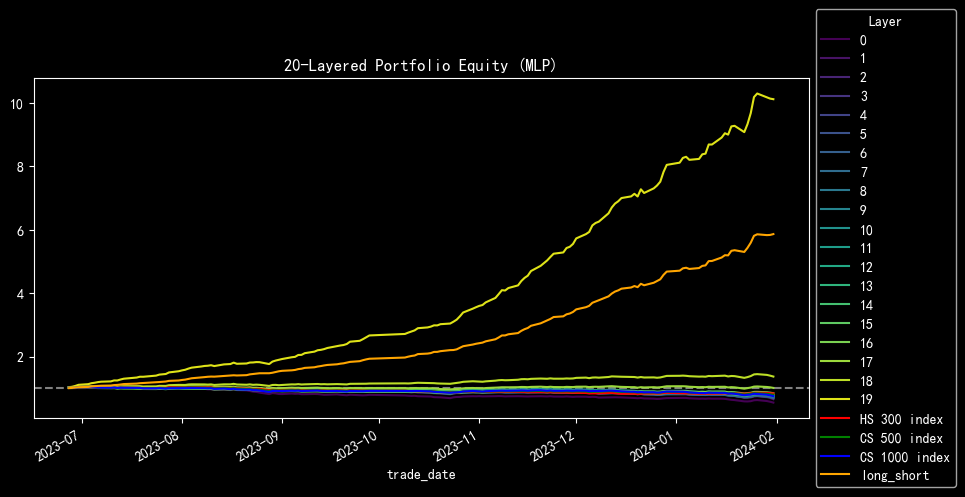

In [18]:
profit_long_MLP, Long_position_df_MLP = Layer_Backtest(MLP_factor_df, 'MLP')

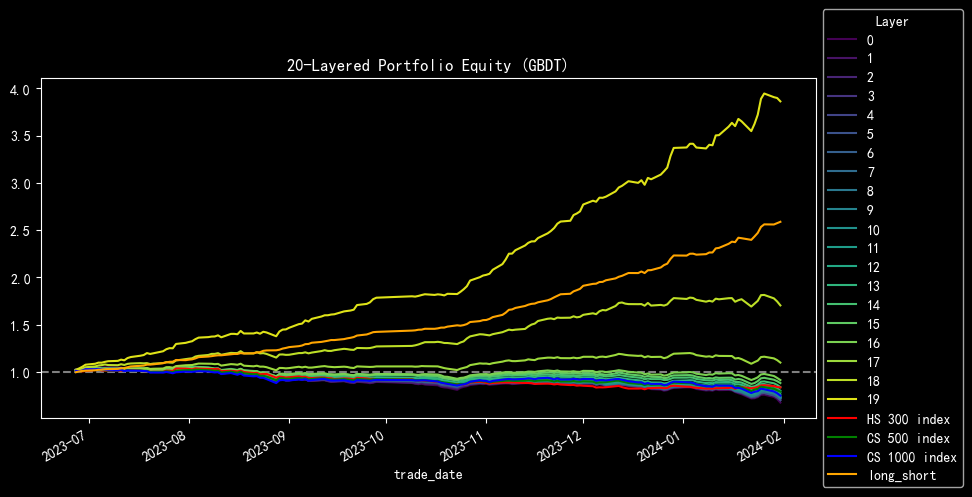

In [19]:
profit_long_GBDT, Long_position_df_GBDT = Layer_Backtest(GBDT_factor_df, 'GBDT')

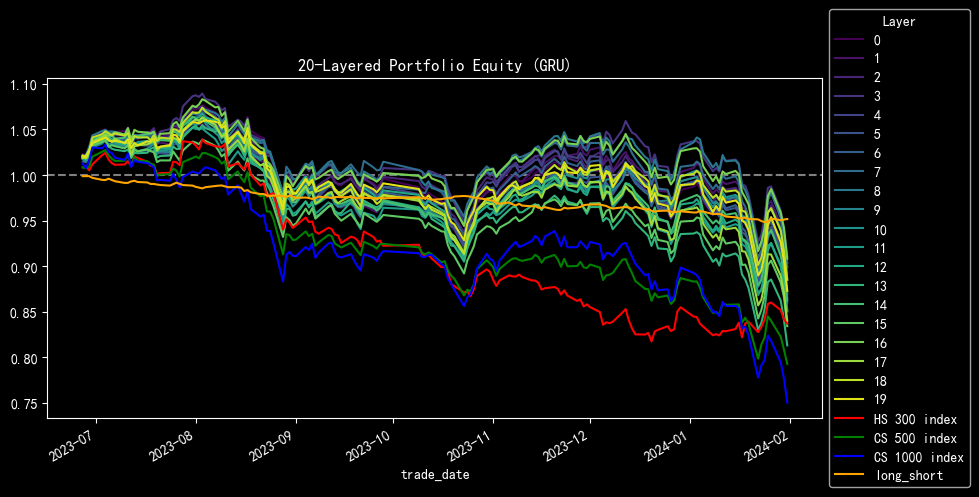

In [20]:
profit_long_GRU, Long_position_df_GRU = Layer_Backtest(GRU_factor_df, 'GRU')

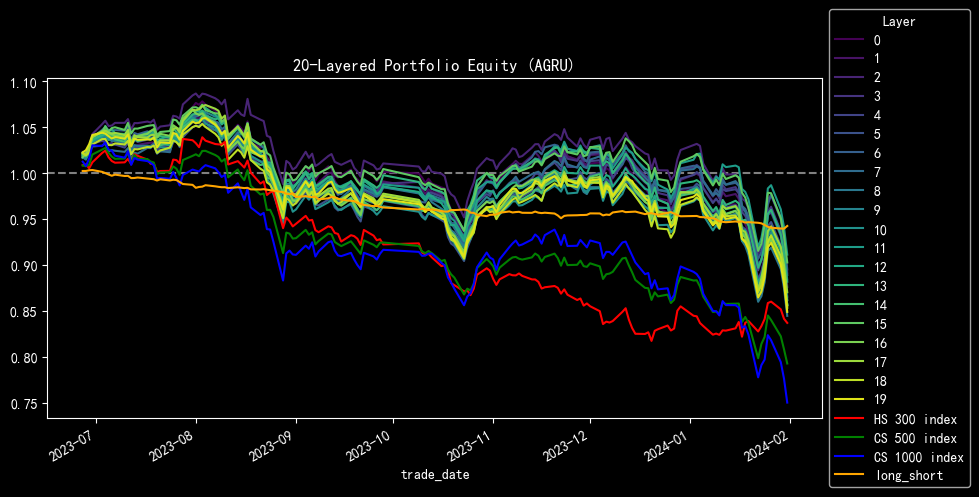

In [21]:
profit_long_AGRU, Long_position_df_AGRU = Layer_Backtest(AGRU_factor_df, 'AGRU')

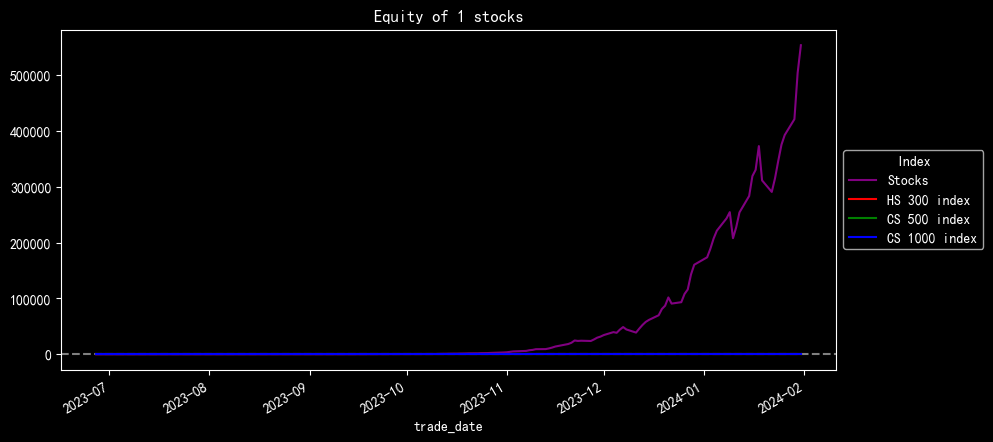

In [22]:
Simple_Backtest(MLP_factor_df, 1)

IC mean: -0.08183487632287945
ICIR: -0.5048858560944581
IC winning rate: 0.28
IC t-value: -0.0412237575259893
Long ROI: 9.113941868742284
Max drawdown: -0.03400620295870854
Max drawdown begin date: 2023-08-28


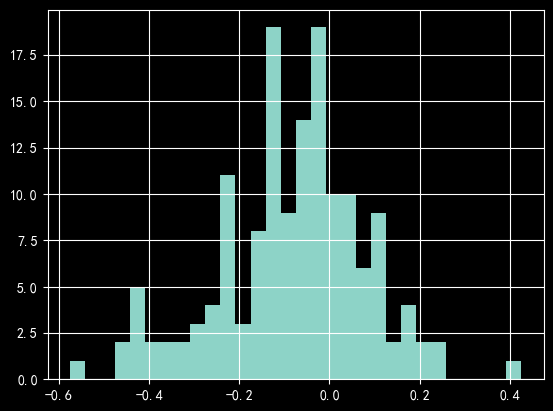

In [23]:
Backtest_Indexes(MLP_factor_df, profit_long_MLP)

IC mean: -0.053771199980919254
ICIR: -0.5053922108804876
IC winning rate: 0.2733333333333333
IC t-value: -0.04126510122114224
Long ROI: 2.8617351794617627
Max drawdown: -0.039161710462881846
Max drawdown begin date: 2023-08-28


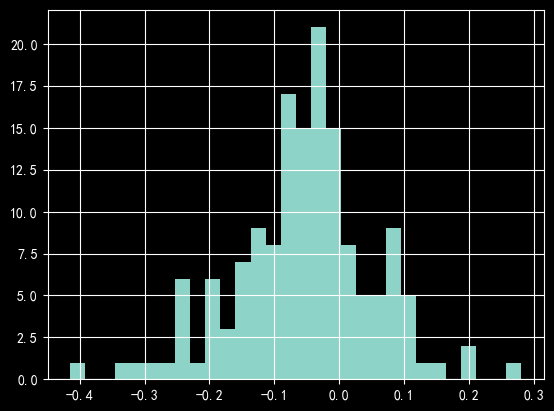

In [25]:
Backtest_Indexes(GBDT_factor_df, profit_long_GBDT)

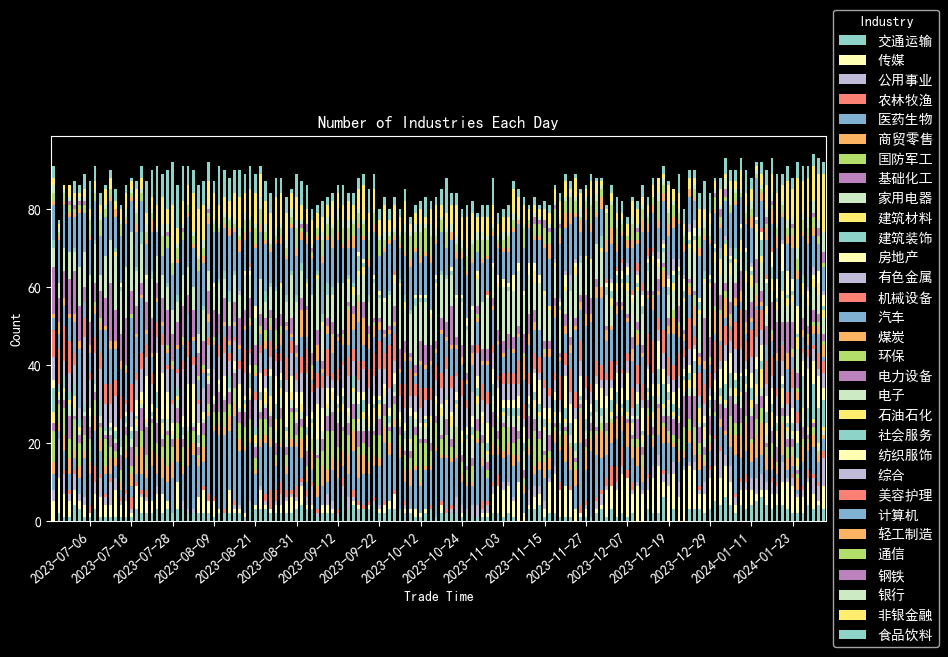

In [24]:
from Position_Industry_Daily import Draw_Industry_Daily
industry_counts = Draw_Industry_Daily(Long_position_df_MLP)